In [2]:
%load_ext autoreload
%autoreload 2
from dsapol import parsec

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from dsapol import dsapol
from scipy.signal import correlate
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.ndimage import convolve1d
from scipy.signal import peak_widths
from scipy.stats import chi
from scipy.stats import norm
import copy
import glob
import csv


from numpy.ma import masked_array as ma
from scipy.stats import kstest
from scipy.optimize import curve_fit


from scipy.signal import find_peaks
from scipy.signal import peak_widths
import copy
import numpy as np

from sigpyproc import FilReader
from sigpyproc.Filterbank import FilterbankBlock
from sigpyproc.Header import Header
from matplotlib import pyplot as plt
import pylab
import pickle
import json
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.stats import chi
from scipy.signal import savgol_filter as sf
from scipy.signal import convolve
from scipy.ndimage import convolve1d
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
from RMtools_1D.do_QUfit_1D_mnest import run_qufit
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

import pandas as pd
import mercury as mr

In [4]:
#http://127.0.0.1:8844/

In [5]:
app = mr.App(title="Polarization Analysis Dashboard", description="With this dashboard, you can conduct RM synthesis, get polarization fractions, and conduct de-dispersion tuning.")

mercury.App

In [ ]:
# (0) Load Data

In [ ]:

#widgets for data loading dashboard
frbfiles = parsec.get_frbfiles()
frbfiles_menu = mr.Select(label="FRB (candname_nickname):", 
                            value=frbfiles[0], choices=frbfiles)
base_n_t_slider = mr.Slider( #time downsampling factor
    value=1,
    min=1, 
    max=128, 
    step=1, 
    label=r'base $n_t$'
)
base_logn_f_slider = mr.Slider( #freq downsampling factor
    value=0,
    min=0, 
    max=10, 
    step=1, 
    label=r'base ${\rm log_{2}}({\rm n_f})$'
)
logibox_slider = mr.Slider(
    value=0,
    min=0, 
    max=6, 
    step=1, 
    label=r'${\rm log_{2}}({\rm ibox})$'
)

buff_L_slider = mr.Slider(
    value=1,
    min=1, 
    max=128, 
    step=1, 
    label=r'${\rm buff}_{L}$'
)
buff_R_slider = mr.Slider(
    value=1,
    min=1, 
    max=128, 
    step=1, 
    label=r'${\rm buff}_{R}$'
)



loadbutton = mr.Button(label='Load FRB Data',style='primary')

#get parameters for default frb
ids = frbfiles_menu.value[:frbfiles_menu.value.index('_')]
RA = parsec.FRB_RA[parsec.FRB_IDS.index(ids)]
DEC = parsec.FRB_DEC[parsec.FRB_IDS.index(ids)]
ibeam = int(parsec.FRB_BEAM[parsec.FRB_IDS.index(ids)])


RA_display = mr.NumberBox(data=RA, title=r'RA ($^{\circ}$)')
DEC_display = mr.NumberBox(data=DEC, title=r'DEC ($^{\circ}$)')
ibeam_display = mr.NumberBox(data=ibeam, title=r'ibeam')

    

In [ ]:
# (1) DM Tuning

In [6]:
#if parsec.state_dict["current_state"] == parsec.state_map['dedisp']:
#widgets for DM tuning dashboard
n_t_slider = mr.Slider( #time downsampling factor
    value=1,
    min=1, 
    max=128, 
    step=1, 
    label='$n_t$'
)
logn_f_slider = mr.Slider( #freq downsampling factor
    value=5,
    min=0, 
    max=10, 
    step=1, 
    label='${\\rm log_{2}}(n_f)$'
)
logwindow_slider = mr.Slider(
    value=5,
    min=5, 
    max=9, 
    step=1, 
    label=r'base ${\rm log_{2}}({\rm window})$'
)
dmstep = parsec.get_min_DM_step(n_t_slider.value)#np.around((32.7e-3)*n_t_slider.value/(4.15)/((1/1.307**2) - (1/1.493**2)),2) #pc/cc
ddm_num = mr.Numeric(value=0, #DM offset
                     step=dmstep,
                     min=-100,max=100,
                     label='$\Delta {\\rm DM}$'
                    )
DM_input_display = mr.NumberBox(data=parsec.FRB_DM[0], 
                                title=r'Input DM (pc/cm$^{{-3}}$)'
                               )
DM_new_display = mr.NumberBox(data=parsec.FRB_DM[0] + ddm_num.value, 
                              title=r'New DM (pc/cm$^{{-3}}$)'
                             )

DMdonebutton = mr.Button(label='Confirm DM',
                         style='primary')



mercury.Slider

mercury.Slider

mercury.Numeric

In [ ]:
# (2) Pol Calibration

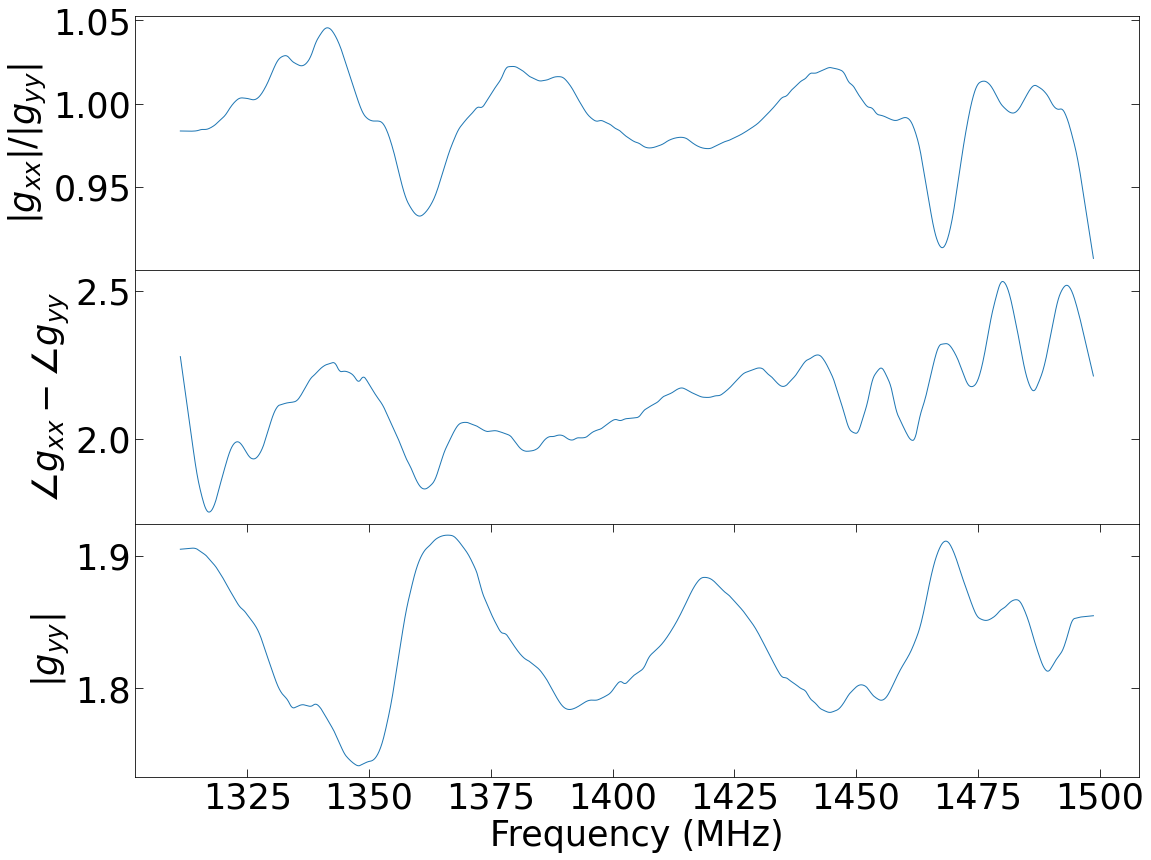

In [6]:
#if parsec.state_dict["current_state"] == parsec.state_map['polcal']:
    
#widgets for pol cal dashboard
polcalfiles = glob.glob(parsec.default_path + 'POLCAL_PARAMETERS_*csv')
polcalfiles = [polcalfiles[i][polcalfiles[i].index('POLCAL'):] for i in range(len(polcalfiles))]
polcaldate_menu = mr.Select(label="Polarization Calibration File ('YY-MM-DD'):", 
                            value=polcalfiles[0], 
                            choices=polcalfiles
                           )

polcalbutton = mr.Button(label='Calibrate',
                         style='primary')
ParA_display = mr.NumberBox(data=np.nan, title=r'Parallactic Angle ($^{\circ}$)')


In [ ]:
# (3) Filter Weights


In [1]:
#widgets for filter weights dashboard

ncomps_num = mr.Numeric(value=1, 
                     step=1,
                     min=1,max=5,
                     label='Number of Components'
                    )
comprange_slider = mr.Range(value=[0,1],  #ms
                        min=0, 
                        max=50, 
                        label="Lower and Upper Limit of Component (ms from window start)", 
                        step=32.7e-3
                )
avger_w_slider = mr.Slider(
    value=1,
    min=1, 
    max=32, 
    step=1, 
    label=r'$n_{tw}$'
)
sf_window_weights_slider = mr.Slider(
    value=3,
    min=3, 
    max=33, 
    step=2, 
    label=r'$sf_{ww}$'
)


NameError: name 'mr' is not defined

In [ ]:
nextcompbutton = mr.Button(label='Next Component',
                         style='primary')

donecompbutton = mr.Button(label='Done',
                         style='primary')




In [ ]:
# Display

# (0) Load Data

In [ ]:
if parsec.state_dict["current_state"] == parsec.state_map['load']:
    #create load data screen
    parsec.load_screen(frbfiles_menu,base_n_t_slider,base_logn_f_slider,logibox_slider,buff_L_slider,buff_R_slider,RA_display,DEC_display,ibeam_display,loadbutton)
    
if not (parsec.state_dict["current_state"] >= parsec.state_map['load']): raise parsec.StopExecution
mr.NumberBox([RA_display,DEC_display,ibeam_display])

# (1) Dedispersion Tuning

In [8]:
if parsec.state_dict["current_state"] == parsec.state_map['dedisp']:
    #create DM screen
    parsec.dedisp_screen(n_t_slider,logn_f_slider,logwindow_slider,ddm_num,DM_input_display,DM_new_display,DMdonebutton)
    
if not (parsec.state_dict["current_state"] >= parsec.state_map['dedisp']): raise parsec.StopExecution
mr.NumberBox([DM_input_display,DM_new_display])
    

# (2) Calibration

In [ ]:
if parsec.state_dict["current_state"] == parsec.state_map['polcal']:
    #create pol cal screen
    parsec.polcal_screen(polcaldate_menu,polcalbutton,ParA_display)
if not (parsec.state_dict["current_state"] >= parsec.state_map['polcal']): raise parsec.StopExecution
ParA_display

# (3) Filter Weights

In [ ]:
if parsec.state_dict["current_state"] == parsec.state_map['filter']:
    
    #create pol cal screen
    parsec.filter_screen(n_t_slider,logn_f_slider,logwindow_slider,logibox_slider,buff_L_slider,buff_R_slider,ncomps_num,comprange_slider,nextcompbutton,donecompbutton,
                        avger_w_slider,sf_window_weights_slider)
    mr.Table(data=parsec.df, width="200px")#, text_align="center")
    
if not (parsec.state_dict["current_state"] >= parsec.state_map['filter']): raise parsec.StopExecution
